<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/Pi_SiGMA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:

# visualization tools
import matplotlib.pyplot as plt

# torch- Our deep learning framework
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim

# from other notebooks
# import import_ipynb
# from dataloaders import DataLoader

In [74]:
# load MNIST dataset both train and test
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [75]:
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PiCon2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True):
        super(PiCon2D, self).__init__()
        self.kernel_size = (kernel_size, kernel_size)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.padding = padding

        # Initialize weights and biases
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

        # Weight and bias initialization
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

        # Define Sigma Conv2D and Fully Connected layers
        self.Sigma_Conv2D = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.Fully_Connected = nn.Sequential(
            nn.Linear(24768, 128),  # Assuming input image size is (1, 28, 28) and after two poolings, the size is (64, 7, 7)
            nn.ReLU(),
            nn.Linear(128, 10)  # Output size is 10 for 10 classes (digits 0-9)
        )

    def pi_conv2d(self, input, weight, bias=None, stride=1, padding=0):
        """
        Function to process an input with a custom convolution.
        """
        batch_size, in_channels, in_h, in_w = input.shape
        out_channels, _, kh, kw = weight.shape

        # Calculate output dimensions
        out_h = (in_h + 2 * padding - kh) // stride + 1
        out_w = (in_w + 2 * padding - kw) // stride + 1

        # Unfold input tensor
        unfold = torch.nn.Unfold(kernel_size=(kh, kw), stride=stride, padding=padding)
        inp_unf = unfold(input)

        # Reshape weight for matrix multiplication
        w_ = weight.view(out_channels, -1).t()

        # Perform convolution
        if bias is None:
            out_unf = torch.exp(torch.log(torch.abs(inp_unf.transpose(1, 2))).matmul(w_).transpose(1, 2))
        else:
            out_unf = (inp_unf.transpose(1, 2).matmul(w_) + bias).transpose(1, 2)

        # Reshape output tensor
        out = out_unf.view(batch_size, out_channels, out_h, out_w)
        return out

    def forward(self, x):
        # PI Conv2D
        z = self.pi_conv2d(x, self.weight, self.bias, self.stride, self.padding)  # Feature extraction
        z = z.reshape(z.size(0), -1)  # Flatten the inputs

        # Sigma Conv2D
        y = self.Sigma_Conv2D(x)
        y = y.reshape(y.size(0), -1)  # Flatten the inputs

        # Concatenate z and y
        concatenated = torch.cat((z, y), dim=1)

        # print(concatenated.size(1))

        # Fully connected layers
        out = self.Fully_Connected(concatenated)
        return F.log_softmax(out, dim=1)  # Softmax activation for classification


In [77]:
model = PiCon2D(1,32)

In [78]:
# loss function
loss_func = nn.CrossEntropyLoss()

In [79]:
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [80]:
def train(epoch):
    model.train()
    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data, target

        output = model(data)

        # Ensure output shape: [batch_size, num_classes]
        # Ensure target shape: [batch_size] with class indices

        # Calculate loss
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        _, pred = output.max(1)  # Get the predicted class
        train_acc += target.eq(pred).sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)  # Correctly normalize accuracy

    return train_loss, train_acc * 100  # Convert accuracy to percentage


In [81]:
def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(test_loader.dataset)
    return val_loss, val_acc

In [82]:
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

--- Epoch 1 ---
	Train loss: 0.2634, acc: 92.1400%
	Val loss: 0.0891, acc: 0.9719%
--- Epoch 2 ---
	Train loss: 0.0720, acc: 97.7700%
	Val loss: 0.0542, acc: 0.9831%
--- Epoch 3 ---
	Train loss: 0.0504, acc: 98.3667%
	Val loss: 0.0550, acc: 0.9810%
--- Epoch 4 ---
	Train loss: 0.0378, acc: 98.8117%
	Val loss: 0.0412, acc: 0.9869%
--- Epoch 5 ---
	Train loss: 0.0283, acc: 99.0817%
	Val loss: 0.0445, acc: 0.9856%
--- Epoch 6 ---
	Train loss: 0.0222, acc: 99.2867%
	Val loss: 0.0373, acc: 0.9880%
--- Epoch 7 ---
	Train loss: 0.0185, acc: 99.4150%
	Val loss: 0.0465, acc: 0.9868%
--- Epoch 8 ---
	Train loss: 0.0139, acc: 99.5200%
	Val loss: 0.0407, acc: 0.9874%
--- Epoch 9 ---
	Train loss: 0.0111, acc: 99.6350%
	Val loss: 0.0560, acc: 0.9855%
--- Epoch 10 ---
	Train loss: 0.0110, acc: 99.6300%
	Val loss: 0.0462, acc: 0.9873%


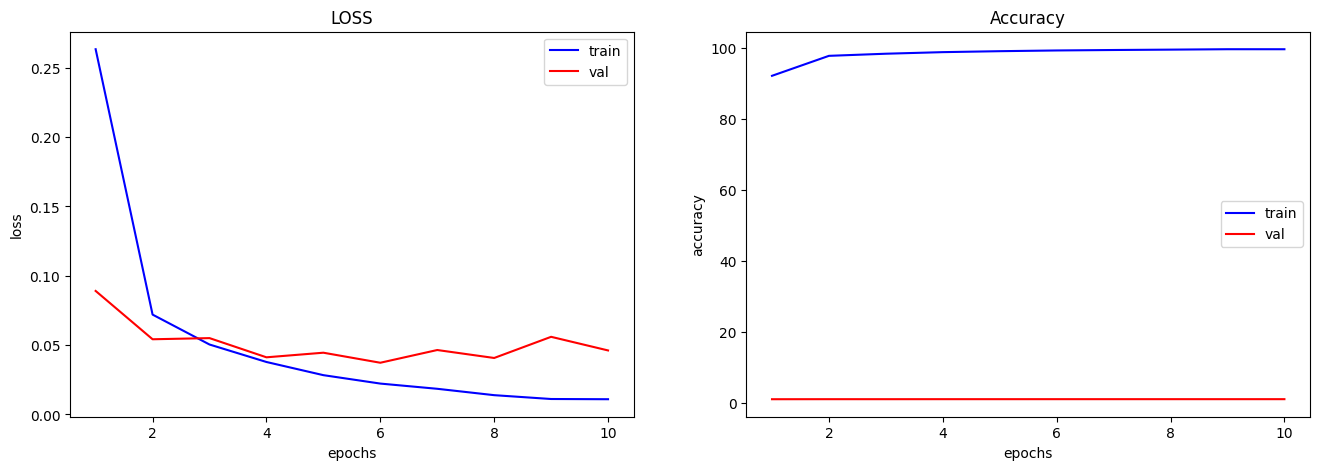

In [83]:
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()